In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 3.8 MB/s 
     |████████████████████████████████| 448 kB 55.5 MB/s 


In [ ]:
import os
import requests
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd

from datetime import datetime
import json
import re

from konlpy.tag import Okt # komoran, han, kkma

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

# 무신사 리뷰 감성분석
- 평점이 아닌 자체적으로 리뷰가 긍정인지 부정인지 판단할 수 있는 기준을 만드는 것이 목표
- 사전만들기 - 점수 부여 - 라벨링 - 모델학습

## 긍정사전, 부정사전 만들기

### 데이터 불러오기

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/2차팀과제/무탠다드_리뷰_라벨.csv', index_col = 0)
df

,상품코드,리뷰내용,별점,label
0,1212777,무탠다드는 믿고 사는 브랜드인것 같네요 다른 색도 사고 싶네요,100,1
1,1212777,허리가 잘 맞고 기장도 널널하니 곱창져서 예뻐요!’ㅜ,60,0
2,1212777,배송은 좀 느렸지만 무탠다드는 역시품질 좋네요잘입고있습니다,100,1
3,1212777,입었을때 바지 핏이 아주 딱 떨어집니다 좋습니다.,100,1
4,1212777,어디에 뭘 입어도 진짜 다 잘 어울리는 바지입니다,100,1
...,...,...,...,...
73615,1801346,이쁘네여 2업 했는데 허리는 크지만 핏이 이뻐용,100,1
73616,1801346,생각보다 두껍고 각이 잘 잡히네요 이쁩니다 만족해요,100,1
73617,1801346,맘에듭니다 그리고 핏도 생각햇던 핏이나와서 좋습니다^^,100,1
73618,1801346,무신사 스탠다드는 항상 믿고 사요! 원단이 튼튼해서 좋아요,100,1


In [ ]:
df_pos_label = df[df['label']==1].reset_index(drop=True)
df_pos_label

,상품코드,리뷰내용,별점,label
0,1212777,무탠다드는 믿고 사는 브랜드인것 같네요 다른 색도 사고 싶네요,100,1
1,1212777,배송은 좀 느렸지만 무탠다드는 역시품질 좋네요잘입고있습니다,100,1
2,1212777,입었을때 바지 핏이 아주 딱 떨어집니다 좋습니다.,100,1
3,1212777,어디에 뭘 입어도 진짜 다 잘 어울리는 바지입니다,100,1
4,1212777,기본에 충실해서 좋아요 무겁지도 않아서 오래 입을거 같아요,100,1
...,...,...,...,...
58995,1801346,이쁘네여 2업 했는데 허리는 크지만 핏이 이뻐용,100,1
58996,1801346,생각보다 두껍고 각이 잘 잡히네요 이쁩니다 만족해요,100,1
58997,1801346,맘에듭니다 그리고 핏도 생각햇던 핏이나와서 좋습니다^^,100,1
58998,1801346,무신사 스탠다드는 항상 믿고 사요! 원단이 튼튼해서 좋아요,100,1


In [ ]:
df_neg_label = df[df['label']==0].reset_index(drop=True)
df_neg_label

,상품코드,리뷰내용,별점,label
0,1212777,허리가 잘 맞고 기장도 널널하니 곱창져서 예뻐요!’ㅜ,60,0
1,1212777,"꽤 두껍고, 기장도 넓고 통도 큽니다. 겨울에 입기 좋은 것 같지만 너무 통바지 느...",60,0
2,1212777,바지 다른거 다 좋은데 허리가 좀 커서 그게 생각보다 거슬려요,60,0
3,1212777,운동 할 때 입으려고 샀는데 좀 튀어나와서 안 될 거 같아요 흠,60,0
4,1212777,재질이 쪼끔 아쉽긴 하지만 남친이 잘 입고 다녀서 조아용,60,0
...,...,...,...,...
2742,1212789,밝은 곳에서는 색상이 사진보다는 좀 더 밝게 나왔습니다,60,0
2743,1212789,한번빨앗더니 짤롱해져서 입을수가없네용ㅜㅜ 색깔이특이합니당,60,0
2744,1212789,라지사이즈가 딱이네요바지색감을 아보카도로 표기했는데 좀 밝았으면 더 만족했을텐데 어...,60,0
2745,1801346,색감이 카키색이라기보단 약간 회색 느낌입니다 밑단 시보리가 너무 느슨해요,60,0


### 리뷰내용 전처리 후 단어별 빈도수 추출

#### 긍정 단어

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()

def text_cleaning(text, stopwords):
    hangul = re.compile('[^ ㄱ-ㅣ 가-힣]')  # 정규 표현식 처리
    result = hangul.sub('', text)
    okt = Okt()  # 형태소 추출
    nouns = okt.nouns(result)
    nouns = [x for x in nouns if len(x) > 1]  # 한글자 키워드 제거
    nouns = [x for x in nouns if x not in stopwords]  # 불용어 제거
    return nouns

vect = CountVectorizer(tokenizer = lambda x: text_cleaning(x, stopwords))
bow_vect = vect.fit_transform(df_pos_label['리뷰내용'].tolist())
word_list = vect.get_feature_names_out()
count_list = bow_vect.toarray().sum(axis=0)

In [ ]:
pos_label_word_count_df = pd.DataFrame({'단어' : word_list, '수' : count_list})
pos_label_word_count_df = pos_label_word_count_df.sort_values('수', ascending=False).reset_index(drop=True)
pos_label_word_count_df.to_csv('/content/drive/MyDrive/2차팀과제/df/긍정 단어 수.csv')
pos_label_word_count_df

,단어,수
0,사이즈,9869
1,허리,6495
2,구매,5604
3,생각,5591
4,바지,5494
...,...,...
8072,암만,1
8073,앏기,1
8074,녹물,1
8075,알쥬,1


#### 부정 단어

In [ ]:
neg_bow_vect = vect.fit_transform(df_neg_label['리뷰내용'].tolist())
neg_word_list = vect.get_feature_names_out()
neg_count_list = neg_bow_vect.toarray().sum(axis=0)

In [ ]:
neg_label_word_count_df = pd.DataFrame({'단어' : neg_word_list, '수' : neg_count_list})
neg_label_word_count_df = neg_label_word_count_df.sort_values('수', ascending=False).reset_index(drop=True)
neg_label_word_count_df.to_csv('/content/drive/MyDrive/2차팀과제/df/부정 단어 수.csv')
neg_label_word_count_df

,단어,수
0,사이즈,561
1,생각,535
2,허리,517
3,바지,340
4,그냥,311
...,...,...
1987,사샤,1
1988,사라,1
1989,뼈대,1
1990,뻣뻣,1


#### 긍정단어, 부정단어 함께보기

In [ ]:
compare_word_count_df = pd.DataFrame({'긍정단어' : pos_label_word_count_df['단어'],
                                      '긍정단어 수' : pos_label_word_count_df['수'],
                                      '부정단어' : neg_label_word_count_df['단어'],
                                      '부정단어 수' : neg_label_word_count_df['수']
                                      })

In [ ]:
compare_word_count_df[:100]

,긍정단어,긍정단어 수,부정단어,부정단어 수
0,사이즈,9869,사이즈,561.0
1,허리,6495,생각,535.0
2,구매,5604,허리,517.0
3,생각,5591,바지,340.0
4,바지,5494,그냥,311.0
...,...,...,...,...
95,검은색,479,다음,27.0
96,무탠다드,476,디자인,27.0
97,세탁,473,종아리,27.0
98,검정,471,건조기,27.0


### 빈도수가 높은 단어에 직접 점수 부여
- 위에서 얻은 데이터프레임을 엑셀로 가져가서 작업진행
- 새로운 점수를 만들기 위해서 긍정단어, 부정단어 각각 빈도수가 높은 약 1000개의 단어에 직접 점수 부여(1:긍정, 0:판단불가, -1:부정)
- 2명이 수행하여 각각 긍정 사전, 부정 사전을 만들고 교집합, 합집합을 추출

#### 데이터 불러오기

In [ ]:
df_1 = pd.read_csv('/content/drive/MyDrive/2차팀과제/csv/긍정 부정 단어 수 같이보기_total - 지성2.csv', index_col = 0)
df_1

,긍정단어,실제 소비자평(긍정),긍정단어 수,부정단어,실제 소비자평(부정),부정단어 수
0,사이즈,0.0,9869,사이즈,0.0,561.0
1,허리,0.0,6495,생각,0.0,535.0
2,구매,0.0,5604,허리,0.0,517.0
3,생각,0.0,5591,바지,0.0,340.0
4,바지,0.0,5494,그냥,0.0,311.0
...,...,...,...,...,...,...
8072,암만,NaN,1,NaN,NaN,NaN
8073,앏기,NaN,1,NaN,NaN,NaN
8074,녹물,NaN,1,NaN,NaN,NaN
8075,알쥬,NaN,1,NaN,NaN,NaN


In [ ]:
df_2 = pd.read_csv('/content/drive/MyDrive/2차팀과제/csv/1000_긍정 부정 단어 수 같이보기_total -.csv', index_col = 0)
df_2

,긍정단어,실제 소비자평(긍정),긍정단어 수,부정단어,실제 소비자평(부정),부정단어 수
0,사이즈,0.0,9869,사이즈,0.0,561.0
1,허리,0.0,6495,생각,0.0,535.0
2,구매,0.0,5604,허리,0.0,517.0
3,생각,0.0,5591,바지,0.0,340.0
4,바지,0.0,5494,그냥,-1.0,311.0
...,...,...,...,...,...,...
8072,암만,NaN,1,NaN,NaN,NaN
8073,앏기,NaN,1,NaN,NaN,NaN
8074,녹물,NaN,1,NaN,NaN,NaN
8075,알쥬,NaN,1,NaN,NaN,NaN


#### 긍정사전, 단어사전 만들기

1번 데이터

In [ ]:
positive_list_1 =[]
negative_list_1 = []
non_list_1 = []

for word, num in zip(df_1['긍정단어'], df_1['실제 소비자평(긍정)']):
  if num == 1.0:
    positive_list_1.append(word)
  elif num == -1.0:
    negative_list_1.append(word)
  elif num == 0.0:
    non_list_1.append(word)
    
for word, num in zip(df_1['부정단어'], df_1['실제 소비자평(부정)']):
  if num == 1.0:
    positive_list_1.append(word)
  elif num == -1.0:
    negative_list_1.append(word)
  elif num == 0.0:
    non_list_1.append(word)

positive_list_1 = list(set(positive_list_1))
negative_list_1 = list(set(negative_list_1))
non_list_1 = list(set(non_list_1))

print(len(positive_list_1), len(negative_list_1), len(non_list_1))

199 140 1362


2번 데이터
- 이 데이터는 점수를 -3~3점으로 줘서 코드가 조금 다름

In [ ]:
positive_list_2 =[]
negative_list_2 = []
non_list_2 = []

for word, num in zip(df_2['긍정단어'], df_2['실제 소비자평(긍정)']):
  if num >= 1.0:
    positive_list_2.append(word)
  elif num <= -1.0:
    negative_list_2.append(word)
  elif num == 0.0:
    non_list_2.append(word)

for word, num in zip(df_2['부정단어'], df_2['실제 소비자평(부정)']):
  if num >= 1.0:
    positive_list_2.append(word)
  elif num <= -1.0:
    negative_list_2.append(word)
  elif num == 0.0:
    non_list_2.append(word)

positive_list_2 = list(set(positive_list_2))
negative_list_2 = list(set(negative_list_2))
non_list_2 = list(set(non_list_2))

print(len(positive_list_2), len(negative_list_2), len(non_list_2))

242 164 1317


사전 통합(교집합)

In [ ]:
c_positive_list = []
c_negative_list = []

for a, b in zip(positive_list_1, positive_list_2):
  if a in positive_list_2:
    c_positive_list.append(a)


for c, d in zip(negative_list_1, negative_list_2):
  if c in negative_list_2:
    c_negative_list.append(c)

print(len(c_positive_list), len(c_negative_list))

156 103


사전 통합(합집합)

In [ ]:
sum_positive_list = positive_list_1 + positive_list_2
sum_negative_list = negative_list_1 + negative_list_2
sum_non_list = non_list_1 + non_list_2

sum_positive_list = list(set(sum_positive_list))
sum_negative_list = list(set(sum_negative_list))
sum_non_list = list(set(sum_non_list))

print(len(sum_positive_list), len(sum_negative_list), len(sum_non_list))


285 201 1431


#### 교집합 단어에 직접 점수 부여(-3점부터 3점까지)
- 교집합 단어 데이터프레임을 엑셀로 가져가서 작업 진행

In [ ]:
df_score = pd.read_csv('/content/drive/MyDrive/2차팀과제/csv/SCORE_1000 단어 점수 세분화.csv', index_col = 0)
df_score

,긍정단어,실제 리뷰 평가(긍정),부정단어,실제 리뷰 평가(부정)
0,압도,3,부각,-2.0
1,다행,1,자꾸,-1.0
2,완젼,3,환불,-3.0
3,다른,1,살바,-2.0
4,정말,3,한철,-1.0
...,...,...,...,...
151,찰떡,3,NaN,NaN
152,젛아,3,NaN,NaN
153,여유,2,NaN,NaN
154,체고,3,NaN,NaN


## 각 리뷰에 사전에 따른 점수를 가지고 총합점수 부여

#### 단어 : 점수를 딕셔너리로 생성

In [ ]:
pos_words = list(df_score['긍정단어'])
pos_scores = list(df_score['실제 리뷰 평가(긍정)'])
neg_words = list(df_score['부정단어'])
neg_words = [x for x in neg_words if pd.isna(x) != True]  # 리스트에서 결측치를 제거
neg_scores = list(df_score['실제 리뷰 평가(부정)'])
neg_scores = [x for x in neg_scores if pd.isna(x) != True]

print(len(pos_words), len(neg_words), len(pos_scores), len(neg_scores))

156 103 156 103


In [ ]:
pos_dict = {}
neg_dict = {}

for word, score in zip(pos_words, pos_scores):
  pos_dict[word] = score

for word, score in zip(neg_words, neg_scores):
  neg_dict[word] = score

print(len(pos_dict), len(neg_dict))

156 103


#### 데이터프레임에 총합점수 추가

In [ ]:
df_review = pd.read_csv('/content/drive/MyDrive/2차팀과제/csv/무탠다드_리뷰.csv', index_col = 0)
df_review

,상품코드,리뷰내용,별점
0,1212777,무탠다드는 믿고 사는 브랜드인것 같네요 다른 색도 사고 싶네요,100
1,1212777,허리가 잘 맞고 기장도 널널하니 곱창져서 예뻐요!’ㅜ,60
2,1212777,배송은 좀 느렸지만 무탠다드는 역시품질 좋네요잘입고있습니다,100
3,1212777,입었을때 바지 핏이 아주 딱 떨어집니다 좋습니다.,100
4,1212777,어디에 뭘 입어도 진짜 다 잘 어울리는 바지입니다,100
...,...,...,...
73615,1801346,이쁘네여 2업 했는데 허리는 크지만 핏이 이뻐용,100
73616,1801346,생각보다 두껍고 각이 잘 잡히네요 이쁩니다 만족해요,100
73617,1801346,맘에듭니다 그리고 핏도 생각햇던 핏이나와서 좋습니다^^,100
73618,1801346,무신사 스탠다드는 항상 믿고 사요! 원단이 튼튼해서 좋아요,100


In [ ]:
df_review['점수'] = 0

In [ ]:
review_contents = list(df_review['리뷰내용'])

for idx, review in tqdm(enumerate(review_contents)):
  score = 0
  for word in pos_words:
    if word in review:
      score += pos_dict[word]
  for word in neg_words:
    if word in review:
      score += neg_dict[word]  # 점수 자체가 음수이므로 더해줘야함
  df_review['점수'][idx] = score

0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
df_review

,상품코드,리뷰내용,별점,점수
0,1212777,무탠다드는 믿고 사는 브랜드인것 같네요 다른 색도 사고 싶네요,100,1
1,1212777,허리가 잘 맞고 기장도 널널하니 곱창져서 예뻐요!’ㅜ,60,2
2,1212777,배송은 좀 느렸지만 무탠다드는 역시품질 좋네요잘입고있습니다,100,3
3,1212777,입었을때 바지 핏이 아주 딱 떨어집니다 좋습니다.,100,3
4,1212777,어디에 뭘 입어도 진짜 다 잘 어울리는 바지입니다,100,3
...,...,...,...,...
73615,1801346,이쁘네여 2업 했는데 허리는 크지만 핏이 이뻐용,100,0
73616,1801346,생각보다 두껍고 각이 잘 잡히네요 이쁩니다 만족해요,100,3
73617,1801346,맘에듭니다 그리고 핏도 생각햇던 핏이나와서 좋습니다^^,100,3
73618,1801346,무신사 스탠다드는 항상 믿고 사요! 원단이 튼튼해서 좋아요,100,3


#### 점수 분포 살펴보기

In [ ]:
df_review.groupby('점수').size()

점수
-11        2
-10        2
-9        10
-8        11
-7        16
-6        91
-5       184
-4       445
-3      1407
-2      1946
-1      5321
 0     25442
 1      5886
 2      7684
 3     12672
 4      3036
 5      2743
 6      3965
 7       814
 8       667
 9       768
 10      174
 11      142
 12      116
 13       27
 14       21
 15       16
 16        4
 17        4
 18        2
 19        1
 20        1
dtype: int64

점수가 0인(라벨을 붙일 수 없는) 리뷰가 25442개
- 약 35%에 해당하는 비율, 너무 많다

### 긍정사전, 부정사전 추가하기

#### 점수가 0인 리뷰를 살펴보고 긍정단어 추가

In [ ]:
df_score0 = df_review[df_review['점수']==0]
df_score0

,상품코드,리뷰내용,별점,점수
6,1212777,"꽤 두껍고, 기장도 넓고 통도 큽니다. 겨울에 입기 좋은 것 같지만 너무 통바지 느...",60,0
7,1212777,딱 정사이즈구요! 생각한 핏 그개로입니다! 무탠다드 짱,100,0
8,1212777,바지 길이가 복숭아 뼈 밑에까지 내려와서 이뻐요,100,0
10,1212777,기장 질감 다 마음에 들지만 한번 세탁하면 줄어들고 질감이 거칠어서 오래 입진 못하...,100,0
15,1212777,스탠다드핏 좋아하면 S가 좋습니다 정핏이에요,100,0
...,...,...,...,...
73609,1801346,밝기가 생각보다는 어두웠지만 차콜과 카키 사이의 오ㅁㅛ한 색깔이 참 맘에 드네요,100,0
73610,1801346,무게감은 좀 있지만 편하게입기 좋은듯해요 가격도 착하내요,100,0
73611,1801346,색감이좋고 사이즈도 잘맞네요 이쁩니다ㅎㅎ잘입을게요,100,0
73613,1801346,착용하였을 때 원단감이나 핏 컬러가 너무 좋습니다.,100,0


In [ ]:
pos_words_add = {'짱': 3, '이뻐요': 3, '이쁘': 3, '편하': 3, '좋고': 3, '좋아': 3, '좋은': 3, '편해': 3, '알맞': 3, '예쁘': 3, '굿': 3}
pos_words_add.update(pos_dict)  # 기존 값이 있다면 기존 값을 유지하기 위해서 이렇게 업데이트를 했다.
print(len(pos_dict), len(pos_words_add))

156 167


In [ ]:
for idx, review in tqdm(enumerate(review_contents)):
  score = 0
  for word in pos_words_add.keys():
    if word in review:
      score += pos_words_add[word]
  for word in neg_words:
    if word in review:
      score += neg_dict[word]  # 점수 자체가 음수이므로 더해줘야함
  df_review['점수'][idx] = score

0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
df_review

,상품코드,리뷰내용,별점,점수
0,1212777,무탠다드는 믿고 사는 브랜드인것 같네요 다른 색도 사고 싶네요,100,1
1,1212777,허리가 잘 맞고 기장도 널널하니 곱창져서 예뻐요!’ㅜ,60,2
2,1212777,배송은 좀 느렸지만 무탠다드는 역시품질 좋네요잘입고있습니다,100,3
3,1212777,입었을때 바지 핏이 아주 딱 떨어집니다 좋습니다.,100,3
4,1212777,어디에 뭘 입어도 진짜 다 잘 어울리는 바지입니다,100,3
...,...,...,...,...
73615,1801346,이쁘네여 2업 했는데 허리는 크지만 핏이 이뻐용,100,3
73616,1801346,생각보다 두껍고 각이 잘 잡히네요 이쁩니다 만족해요,100,3
73617,1801346,맘에듭니다 그리고 핏도 생각햇던 핏이나와서 좋습니다^^,100,3
73618,1801346,무신사 스탠다드는 항상 믿고 사요! 원단이 튼튼해서 좋아요,100,6


In [ ]:
df_review.groupby('점수').size()

점수
-11        1
-10        2
-9         8
-8         7
-7        13
-6        46
-5       124
-4       237
-3       832
-2      1101
-1      3014
 0     11743
 1      3371
 2      5389
 3     15013
 4      3931
 5      4856
 6     10646
 7      2316
 8      2414
 9      4405
 10      917
 11      855
 12     1362
 13      239
 14      207
 15      358
 16       61
 17       46
 18       60
 19       10
 20        7
 21       13
 22        3
 23        6
 24        3
 25        4
dtype: int64

점수가 0인 리뷰가 11743개로 감소, 하지만 점수가 1 이상인 리뷰가 상대적으로 더 많아진 것을 볼 수 있다.( 부정사전 추가 필요 )

#### 점수가 0인 리뷰를 살펴보고 부정사전 추가

In [ ]:
df_score00 = df_review[df_review['점수']==0]
df_score00

,상품코드,리뷰내용,별점,점수
10,1212777,기장 질감 다 마음에 들지만 한번 세탁하면 줄어들고 질감이 거칠어서 오래 입진 못하...,100,0
25,1212777,일자핏보다 조금 더 와이드핏으로 무난하고 편한바지,80,0
57,1212777,너무 마음에 드는 전투용 스웨트 팬츠입니다.더스티 베이지도 추가적으로 구매할 생각입니다.,100,0
68,1212777,딱 원하는 스타일의 상품 싸게 잘 마련한 것 같습니다,100,0
77,1212777,색이나 기장이나 모두 무난합니다 다만 잘 늘어날듯,100,0
...,...,...,...,...
73595,1801346,입을만 합니다. 가을에 입기 좋겠어요. 안에 타이즈 하나 입으면 겨울까지도,80,0
73598,1801346,차콜색에다가 은은한 카키색이 도는 느낌입니다. 잘 입겠습니다.,100,0
73605,1801346,싸이즈 딱이고 원단 두께감이 좀있어서 좋네요 가을용으로 딱이네요,100,0
73609,1801346,밝기가 생각보다는 어두웠지만 차콜과 카키 사이의 오ㅁㅛ한 색깔이 참 맘에 드네요,100,0


In [ ]:
neg_words_add = {'큽니': -1, '아쉬': -1, '크네': -1, '생각보다': -1, '안입': -2, '안갈': -1, '안찾': -1, '미스': -2, '커요': -1, '힘들': -1, '안옴': -2, '선넘': -2, '싸보': -2,
                 '개커': -1, '못입': -2, '보관': -1, '무릎발사': -1}
neg_words_add.update(neg_dict)
print(len(neg_dict), len(neg_words_add))

103 120


In [ ]:
for idx, review in tqdm(enumerate(review_contents)):
  score = 0
  for word in pos_words_add.keys():
    if word in review:
      score += pos_words_add[word]
  for word in neg_words_add.keys():
    if word in review:
      score += neg_words_add[word]  
  df_review['점수'][idx] = score

0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
df_review

,상품코드,리뷰내용,별점,점수
0,1212777,무탠다드는 믿고 사는 브랜드인것 같네요 다른 색도 사고 싶네요,100,1
1,1212777,허리가 잘 맞고 기장도 널널하니 곱창져서 예뻐요!’ㅜ,60,2
2,1212777,배송은 좀 느렸지만 무탠다드는 역시품질 좋네요잘입고있습니다,100,3
3,1212777,입었을때 바지 핏이 아주 딱 떨어집니다 좋습니다.,100,3
4,1212777,어디에 뭘 입어도 진짜 다 잘 어울리는 바지입니다,100,3
...,...,...,...,...
73615,1801346,이쁘네여 2업 했는데 허리는 크지만 핏이 이뻐용,100,3
73616,1801346,생각보다 두껍고 각이 잘 잡히네요 이쁩니다 만족해요,100,2
73617,1801346,맘에듭니다 그리고 핏도 생각햇던 핏이나와서 좋습니다^^,100,3
73618,1801346,무신사 스탠다드는 항상 믿고 사요! 원단이 튼튼해서 좋아요,100,6


In [ ]:
df_review.groupby('점수').size()

점수
-11        1
-10        4
-9        10
-8         9
-7        28
-6        74
-5       182
-4       397
-3      1012
-2      1815
-1      4446
 0      9834
 1      3870
 2      6219
 3     13534
 4      4090
 5      5201
 6      9809
 7      2362
 8      2498
 9      4152
 10      908
 11      874
 12     1285
 13      247
 14      207
 15      343
 16       65
 17       43
 18       55
 19       11
 20        7
 21       12
 22        4
 23        6
 24        5
 25        1
dtype: int64

#### 점수가 0인, 별점이 60이하인 리뷰를 살펴보고 부정사전 2차 추가

In [ ]:
df_score000 = df_review[(df_review['점수']==0) & (df_review['별점'] <= 60)]
df_score000

,상품코드,리뷰내용,별점,점수
294,1212777,같은 제품 블랙보다 더 작은 느낌이 드네요 착용감도 그렇고 착샷이 더 작아보여요.,60,0
309,1212777,기장이 좀 짧네요. 후기 보면 기장이 길다고들 하시던데 좀 더 길었으면 좋겠어요.,60,0
561,1212777,너무 이쁩니다. 꼭 사세요 핏이 너무 좋습니다. 다음에 또 사겠습니다.,60,0
1093,1212777,길이가좀 짧고 무릎도 좀 나옵니다.통은 꽤 넓어요.,60,0
1310,1212777,사진만큼 와이드하지않아요 찐 와이드 원하시면 단거사세요,60,0
...,...,...,...,...
72981,965995,"그냥 비닐 느낌 싼 느낌의 바지, 산책이나 어디 시장 갈 때 입는 옷",40,0
73141,1629083,전 넘잘입어서 남친것도 사줬는데 보통 나이키 엑스라지입어서 동일하게 샀지만 넘...,60,0
73215,1801821,주머니부분이 살짝 보이는 정도예요 비침이 약간 있네요 그리 탄탄하지는 않은 것 같습니다,60,0
73492,1212789,밝은 곳에서는 색상이 사진보다는 좀 더 밝게 나왔습니다,60,0


In [ ]:
neg_words_add2 = {'취약': -1, '심한':-1, '아싑':-1, '묻어':-1, '심합':-1, '버렸':-2, '이상':-1, '검수':-1, '수선':-1, '흠':-1, '빵꾸':-1,
                  '않네':-1, '늘어':-1, '처참':-2, '슬프':-1, '구멍':-1, '상합':-1, '애매':-1, '슬펏':-1, '수축':-1, '짝짝':-1, '곤란': -1,
                  '부해':-1, '에바':-1, '별로':-1, '안예':-1, '후줄근':-1, '밑위':-1, '뭉개':-1, '똥':-1, '실망':-1, '심각':-1, '늦네':-1,
                  '상이':-1, '하타치':-1, '춥고':-1, '빡쳐':-1, '개빡':-1, '어정쩡':-1, '까칠':-1, '최악':-3 
                  }

neg_words_add2.update(neg_words_add)
print(len(neg_words_add), len(neg_words_add2))

120 157


In [ ]:
for idx, review in tqdm(enumerate(review_contents)):
  score = 0
  for word in pos_words_add.keys():
    if word in review:
      score += pos_words_add[word]
  for word in neg_words_add2.keys():
    if word in review:
      score += neg_words_add2[word]  
  df_review['점수'][idx] = score

0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
df_review

,상품코드,리뷰내용,별점,점수
0,1212777,무탠다드는 믿고 사는 브랜드인것 같네요 다른 색도 사고 싶네요,100,1
1,1212777,허리가 잘 맞고 기장도 널널하니 곱창져서 예뻐요!’ㅜ,60,2
2,1212777,배송은 좀 느렸지만 무탠다드는 역시품질 좋네요잘입고있습니다,100,3
3,1212777,입었을때 바지 핏이 아주 딱 떨어집니다 좋습니다.,100,3
4,1212777,어디에 뭘 입어도 진짜 다 잘 어울리는 바지입니다,100,3
...,...,...,...,...
73615,1801346,이쁘네여 2업 했는데 허리는 크지만 핏이 이뻐용,100,3
73616,1801346,생각보다 두껍고 각이 잘 잡히네요 이쁩니다 만족해요,100,2
73617,1801346,맘에듭니다 그리고 핏도 생각햇던 핏이나와서 좋습니다^^,100,3
73618,1801346,무신사 스탠다드는 항상 믿고 사요! 원단이 튼튼해서 좋아요,100,6


In [ ]:
df_review.groupby('점수').size()

점수
-11        2
-10        8
-9         8
-8        17
-7        34
-6       105
-5       201
-4       462
-3      1053
-2      2151
-1      4761
 0      9324
 1      4060
 2      6557
 3     12941
 4      4212
 5      5322
 6      9434
 7      2372
 8      2550
 9      4019
 10      904
 11      877
 12     1258
 13      241
 14      202
 15      342
 16       61
 17       42
 18       58
 19        8
 20        7
 21       11
 22        5
 23        7
 24        3
 25        1
dtype: int64

## 점수를 기준으로 라벨 부여(긍정 : 1 , 판단불가 : 0 , 부정 : -1)

In [ ]:
df_review['label'] = 2

for idx, score in tqdm(enumerate(df_review['점수'])):
  if score > 0:
    label = 1
  elif score <0:
    label = -1
  else:
    label = 0
  df_review['label'][idx] = label

df_review

0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,상품코드,리뷰내용,별점,점수,label
0,1212777,무탠다드는 믿고 사는 브랜드인것 같네요 다른 색도 사고 싶네요,100,1,1
1,1212777,허리가 잘 맞고 기장도 널널하니 곱창져서 예뻐요!’ㅜ,60,2,1
2,1212777,배송은 좀 느렸지만 무탠다드는 역시품질 좋네요잘입고있습니다,100,3,1
3,1212777,입었을때 바지 핏이 아주 딱 떨어집니다 좋습니다.,100,3,1
4,1212777,어디에 뭘 입어도 진짜 다 잘 어울리는 바지입니다,100,3,1
...,...,...,...,...,...
73615,1801346,이쁘네여 2업 했는데 허리는 크지만 핏이 이뻐용,100,3,1
73616,1801346,생각보다 두껍고 각이 잘 잡히네요 이쁩니다 만족해요,100,2,1
73617,1801346,맘에듭니다 그리고 핏도 생각햇던 핏이나와서 좋습니다^^,100,3,1
73618,1801346,무신사 스탠다드는 항상 믿고 사요! 원단이 튼튼해서 좋아요,100,6,1


In [ ]:
df_review.groupby('label').size()

label
-1     8802
 0     9324
 1    55494
dtype: int64

## 모델학습

### 학습 데이터 불러오기

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/2차팀과제/df/리뷰판단학습데이터.csv', index_col = 0)
df

,상품코드,리뷰내용,별점,점수,label
0,1212777,무탠다드는 믿고 사는 브랜드인것 같네요 다른 색도 사고 싶네요,100,1,1
1,1212777,허리가 잘 맞고 기장도 널널하니 곱창져서 예뻐요!’ㅜ,60,2,1
2,1212777,배송은 좀 느렸지만 무탠다드는 역시품질 좋네요잘입고있습니다,100,3,1
3,1212777,입었을때 바지 핏이 아주 딱 떨어집니다 좋습니다.,100,3,1
4,1212777,어디에 뭘 입어도 진짜 다 잘 어울리는 바지입니다,100,3,1
...,...,...,...,...,...
73615,1801346,이쁘네여 2업 했는데 허리는 크지만 핏이 이뻐용,100,3,1
73616,1801346,생각보다 두껍고 각이 잘 잡히네요 이쁩니다 만족해요,100,2,1
73617,1801346,맘에듭니다 그리고 핏도 생각햇던 핏이나와서 좋습니다^^,100,3,1
73618,1801346,무신사 스탠다드는 항상 믿고 사요! 원단이 튼튼해서 좋아요,100,6,1


라벨 0인 데이터 제거

In [ ]:
df = df[~(df['label']==0)]
df = df.reset_index(drop=True)
df

,상품코드,리뷰내용,별점,점수,label
0,1212777,무탠다드는 믿고 사는 브랜드인것 같네요 다른 색도 사고 싶네요,100,1,1
1,1212777,허리가 잘 맞고 기장도 널널하니 곱창져서 예뻐요!’ㅜ,60,2,1
2,1212777,배송은 좀 느렸지만 무탠다드는 역시품질 좋네요잘입고있습니다,100,3,1
3,1212777,입었을때 바지 핏이 아주 딱 떨어집니다 좋습니다.,100,3,1
4,1212777,어디에 뭘 입어도 진짜 다 잘 어울리는 바지입니다,100,3,1
...,...,...,...,...,...
64291,1801346,이쁘네여 2업 했는데 허리는 크지만 핏이 이뻐용,100,3,1
64292,1801346,생각보다 두껍고 각이 잘 잡히네요 이쁩니다 만족해요,100,2,1
64293,1801346,맘에듭니다 그리고 핏도 생각햇던 핏이나와서 좋습니다^^,100,3,1
64294,1801346,무신사 스탠다드는 항상 믿고 사요! 원단이 튼튼해서 좋아요,100,6,1


### 벡터화

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()

def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ 가-힣]')  # 정규 표현식 처리
    result = hangul.sub('', text)
    okt = Okt()  # 형태소 추출
    nouns = okt.nouns(result)
    nouns = [x for x in nouns if len(x) > 1]  # 한글자 키워드 제거
    nouns = [x for x in nouns if x not in stopwords]  # 불용어 제거
    return nouns

vect = CountVectorizer(tokenizer = lambda x: text_cleaning(x))
bow_vect = vect.fit_transform(df['리뷰내용'].tolist())
word_list = vect.get_feature_names_out()
count_list = bow_vect.toarray().sum(axis=0)

### TF-IDF로 변환

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_vectorizer = TfidfTransformer()
tf_idf_vect = tfidf_vectorizer.fit_transform(bow_vect)

### 학습데이터, 검증데이터로 분리

In [ ]:
from sklearn.model_selection import train_test_split

x = tf_idf_vect
y = df['label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=1)


In [ ]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(45007, 8599) (45007,)
(19289, 8599) (19289,)


### 로지스틱 회귀분류로 학습

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# fit in training set
lr = LogisticRegression(random_state = 0, max_iter=1000) 
lr.fit(x_train, y_train)

# predict in test set
y_pred = lr.predict(x_test)

### 점수 확인

In [ ]:
# classification result for test set

print('accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('precision: %.2f' % precision_score(y_test, y_pred))
print('recall: %.2f' % recall_score(y_test, y_pred))
print('F1: %.2f' % f1_score(y_test, y_pred))

accuracy: 0.88
precision: 0.90
recall: 0.97
F1: 0.93


In [ ]:
original_sample = [0.88, 0.90, 0.97, 0.93]

### 시각화

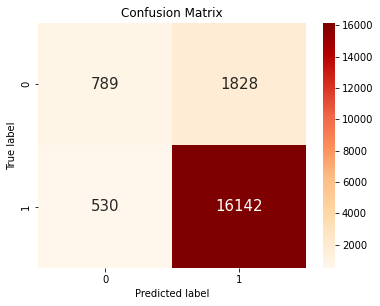

In [ ]:
# confusion matrix

from sklearn.metrics import confusion_matrix

confu = confusion_matrix(y_true = y_test, y_pred = y_pred)

plt.figure(figsize=(6, 4.5))
sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

대부분을 1이라고 판단함. 0인데 1이라고 판단한게 너무 많음(1828개)

### 긍정, 부정 키워드 분석

In [ ]:
lr.coef_

array([[-0.55102067,  0.01023245,  0.03092747, ...,  0.        ,
         0.09346642,  0.13649762]])

<BarContainer object of 8599 artists>

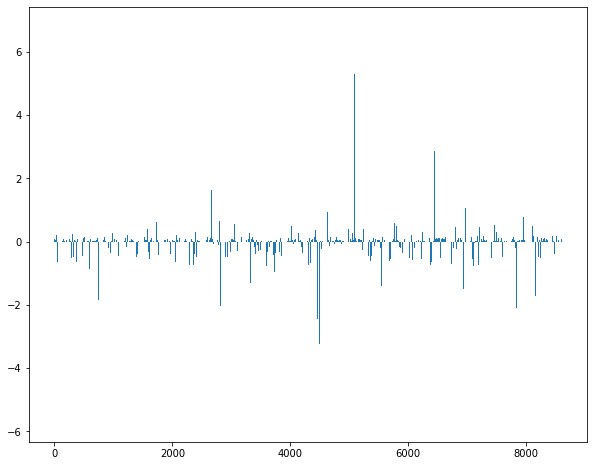

In [ ]:
plt.figure(figsize=(10, 8))
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])


In [ ]:
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse = True)
coef_neg_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse = False)
len(coef_pos_index)

8599

In [ ]:
invert_index_vectorizer = {v: k for k, v in vect.vocabulary_.items()}

In [ ]:
words_info = {
    '단어' : [],
    '점수' : []
}

for coef in coef_pos_index:
  words_info['단어'].append(invert_index_vectorizer[coef[1]])
  words_info['점수'].append(coef[0])

df_words_info = pd.DataFrame(words_info)

In [ ]:
df_words_info

,단어,점수
0,아주,6.788150
1,추천,6.393087
2,진짜,6.199416
3,정말,5.890349
4,완전,5.670822
...,...,...
8594,문제,-4.232592
8595,반품,-4.284980
8596,후회,-4.572459
8597,무거워,-4.692130


### 언더 샘플링

In [ ]:
positive_random_idx = df[df['label']==1].sample(8802, random_state=12).index.tolist()
negative_random_idx = df[df['label']==-1].sample(8802, random_state=12).index.tolist()

In [ ]:
random_idx = positive_random_idx + negative_random_idx
x = tf_idf_vect[random_idx]
y = df['label'][random_idx]
x_train_under, x_test_under, y_train_under, y_test_under = train_test_split(x, y, test_size=0.25, random_state=1)

In [ ]:
print(x_train_under.shape, y_train_under.shape)
print(x_test_under.shape, y_test_under.shape)

(13203, 8599) (13203,)
(4401, 8599) (4401,)


In [ ]:
lr2 = LogisticRegression(random_state = 0)
lr2.fit(x_train_under, y_train_under)
y_pred_under = lr2.predict(x_test_under)

In [ ]:
# classification result for test set

print('accuracy: %.2f' % accuracy_score(y_test_under, y_pred_under))
print('precision: %.2f' % precision_score(y_test_under, y_pred_under))
print('recall: %.2f' % recall_score(y_test_under, y_pred_under))
print('F1: %.2f' % f1_score(y_test_under, y_pred_under))

accuracy: 0.82
precision: 0.83
recall: 0.81
F1: 0.82


In [ ]:
under_sample = [0.82, 0.83, 0.81, 0.82]

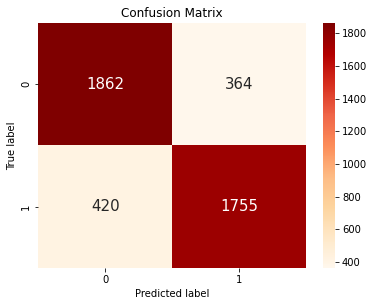

In [ ]:
# confusion matrix

from sklearn.metrics import confusion_matrix

confu = confusion_matrix(y_true = y_test_under, y_pred = y_pred_under)


plt.figure(figsize=(6, 4.5))
sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

### 오버 샘플링

SMOTE를 이용해서 오버샘플링

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()

In [ ]:
from sklearn.model_selection import train_test_split

x = tf_idf_vect
y = df['label']
x_train, x_test_smt, y_train, y_test_smt = train_test_split(x, y, test_size = 0.3, random_state=1)


In [ ]:
x_train  # 45007개 중에서 -1이 6185, 1이 38822

<45007x8599 sparse matrix of type '<class 'numpy.float64'>'
	with 189881 stored elements in Compressed Sparse Row format>

In [ ]:
x_train_smt,y_train_smt = smote.fit_resample(x_train, y_train)
x_train_smt,y_train_smt

(<77644x8599 sparse matrix of type '<class 'numpy.float64'>'
 	with 367912 stored elements in Compressed Sparse Row format>, 0        1
 1       -1
 2        1
 3        1
 4        1
         ..
 77639   -1
 77640   -1
 77641   -1
 77642   -1
 77643   -1
 Name: label, Length: 77644, dtype: int64)

In [ ]:
print('smote 전 :', np.unique(y_train, return_counts=True))
print('smote 후 :', np.unique(y_train_smt, return_counts=True))

smote 전 : (array([-1,  1]), array([ 6185, 38822]))
smote 후 : (array([-1,  1]), array([38822, 38822]))


In [ ]:
print(x_train_smt.shape, y_train_smt.shape)
print(x_test_smt.shape, y_test_smt.shape)

(77644, 8599) (77644,)
(19289, 8599) (19289,)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

lr3 = LogisticRegression(random_state = 0, max_iter=1000)
lr3.fit(x_train_smt, y_train_smt)
y_pred_smt = lr3.predict(x_test_smt)

In [ ]:
# classification result for test set

print('accuracy: %.2f' % accuracy_score(y_test_smt, y_pred_smt))
print('precision: %.2f' % precision_score(y_test_smt, y_pred_smt))
print('recall: %.2f' % recall_score(y_test_smt, y_pred_smt))
print('F1: %.2f' % f1_score(y_test_smt, y_pred_smt))

accuracy: 0.81
precision: 0.97
recall: 0.80
F1: 0.88


In [ ]:
over_sample = [0.81, 0.97, 0.80, 0.88]

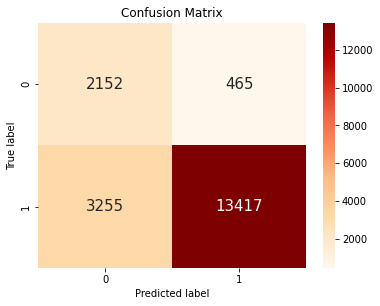

In [ ]:
# confusion matrix

from sklearn.metrics import confusion_matrix

confu = confusion_matrix(y_true = y_test_smt, y_pred = y_pred_smt) # (행, 열) y_ture가 행이고, y_pred가 열(컬럼)

plt.figure(figsize=(6, 4.5))
sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

오버 샘플링(부정데이터를 오버 샘플링)
- 1(긍정)인데 0(부정)이라고 판단하는게 많아졌다

### 종합 시각화

In [ ]:
column_list = ['Accuracy', 'Precision', 'Recall', 'F1']
index_list = ['Orginal-sample', 'Under-sampling', 'Over-sampling']
df_score = pd.DataFrame([original_sample, under_sample, over_sample], columns=column_list, index=index_list)
df_score.T


,Orginal-sample,Under-sampling,Over-sampling
Accuracy,0.88,0.82,0.81
Precision,0.90,0.83,0.97
Recall,0.97,0.81,0.80
F1,0.93,0.82,0.88


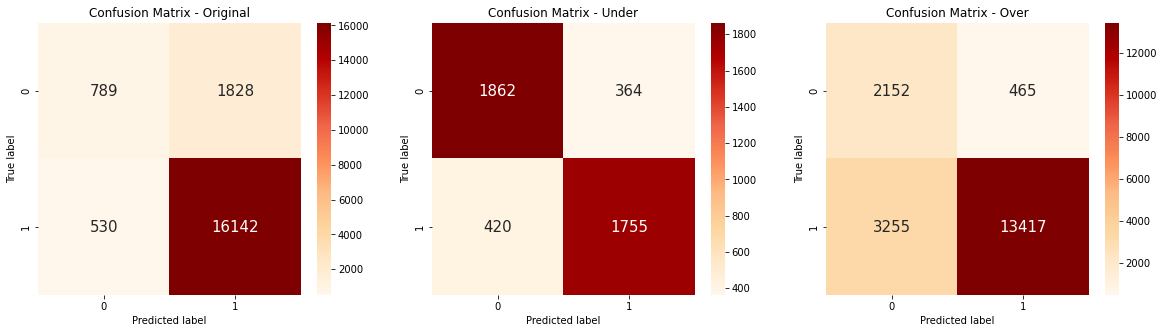

,Orginal-sample,Under-sampling,Over-sampling
Accuracy,0.88,0.82,0.81
Precision,0.90,0.83,0.97
Recall,0.97,0.81,0.80
F1,0.93,0.82,0.88


In [ ]:
fig, ax = plt.subplots(ncols=3,  figsize=(20, 5))

confu_org = confusion_matrix(y_true = y_test, y_pred = y_pred)
confu_under = confusion_matrix(y_true = y_test_under, y_pred = y_pred_under)
confu_over = confusion_matrix(y_true = y_test_smt, y_pred = y_pred_smt)


sns.heatmap(confu_org, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g', ax = ax[0])
ax[0].set_ylabel('True label')
ax[0].set_xlabel('Predicted label')
ax[0].set_title('Confusion Matrix - Original')


sns.heatmap(confu_under, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g', ax = ax[1])
ax[1].set_ylabel('True label')
ax[1].set_xlabel('Predicted label')
ax[1].set_title('Confusion Matrix - Under')


sns.heatmap(confu_over, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g', ax = ax[2])
ax[2].set_ylabel('True label')
ax[2].set_xlabel('Predicted label')
ax[2].set_title('Confusion Matrix - Over')

plt.show()

print('\n')
print('\n')
df_score.T
